# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

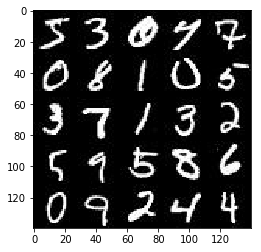

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

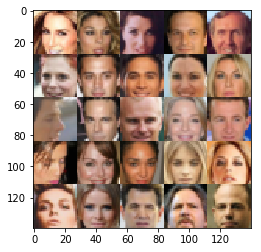

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/jon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropout = tf.layers.dropout(relu3, training=True)
        
        flat = tf.reshape(dropout, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        discriminator_output = tf.sigmoid(logits)

    return discriminator_output, logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
       
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
  
    return out 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_real, 
            labels=tf.ones_like(discriminator_model_real)
        )
    )
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_fake, 
            labels=tf.zeros_like(discriminator_model_fake) * 0.9
        )
    )
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_fake, 
            labels=tf.ones_like(discriminator_model_fake)
        )
    )

    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        descriminator_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        generator_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return descriminator_train_op, generator_train_op

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    discriminator_op, generator_op = model_opt(discriminator_loss, generator_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(discriminator_op, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(generator_op, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 2.0284
Epoch 1/2... Discriminator Loss: 3.1164... Generator Loss: 0.0889
Epoch 1/2... Discriminator Loss: 1.8710... Generator Loss: 0.2923
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 1.4746
Epoch 1/2... Discriminator Loss: 2.6438... Generator Loss: 0.1559
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 1.2294
Epoch 1/2... Discriminator Loss: 1.5164... Generator Loss: 2.4131


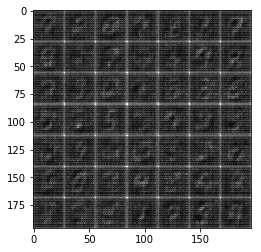

Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 1.0787
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.4886
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.6948


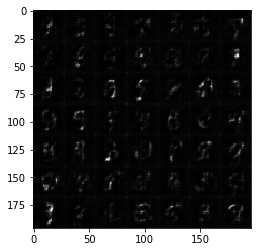

Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.7697
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.2490
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.0020


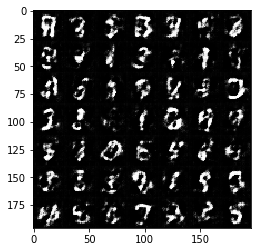

Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.4346
Epoch 1/2... Discriminator Loss: 0.4284... Generator Loss: 1.9254
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.7750
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.2506
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 1.7526
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 1.0046


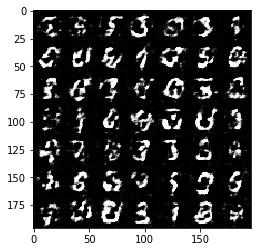

Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 2.4931
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.6850
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 0.8558
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 1.7360
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 2.0430
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 2.3275


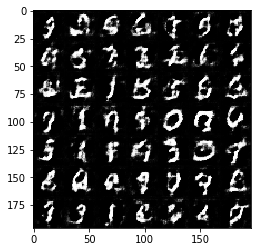

Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 2.0348
Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.1894
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 1.8918
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.1054
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 2.8670
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 2.2887
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 3.1352
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.7260


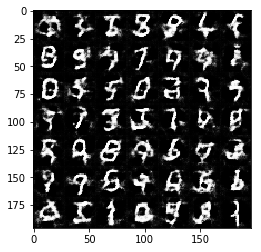

Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.1364
Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.4688
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.4149
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.6725
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.6104
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.7809


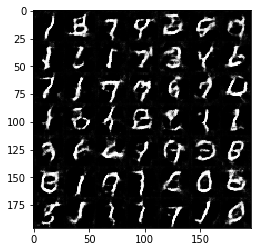

Epoch 1/2... Discriminator Loss: 1.8440... Generator Loss: 0.3869
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.7159
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 2.7655
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 1.7211
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 1.0155


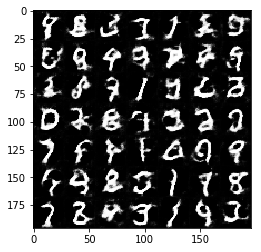

Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 0.5591... Generator Loss: 1.9224
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 1.1202
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.3786
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 1.8784... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.6267
Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 1.4801


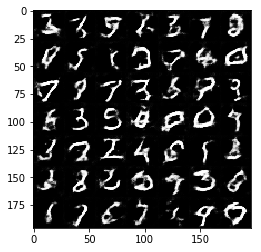

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.1080
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 1.8720
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 0.4998... Generator Loss: 1.7260
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.7844


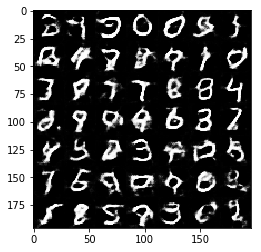

Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.8610
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.6309


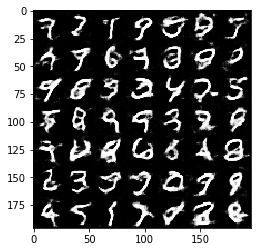

Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 1.4828
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.9088
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.4011
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 2.0980
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 2.2928
Epoch 1/2... Discriminator Loss: 0.8689... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.2353


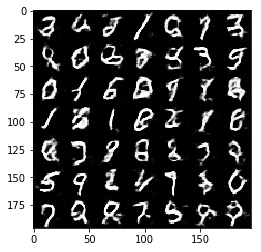

Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 2.2552
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.4688
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.0737


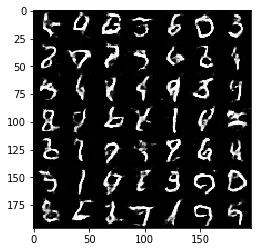

Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 1.9558... Generator Loss: 0.3458
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.3693
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.5564
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.8102... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.3085
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.6728
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 0.9450


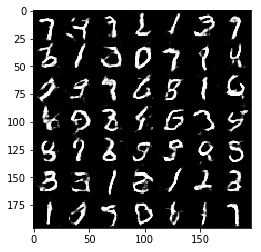

Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 2.1927
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.5032
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 1.6545
Epoch 1/2... Discriminator Loss: 1.6110... Generator Loss: 2.8162
Epoch 1/2... Discriminator Loss: 0.6106... Generator Loss: 2.3546


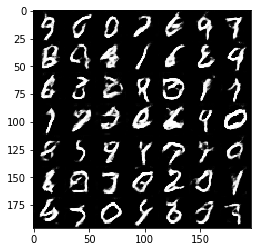

Epoch 1/2... Discriminator Loss: 1.6870... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 1.3176
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 0.8362... Generator Loss: 1.2783
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 1.9533
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.9724


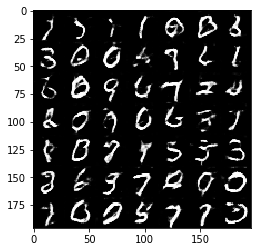

Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 2.0900
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 1.5772
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 0.3137... Generator Loss: 2.3197
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 1.7354
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.8033


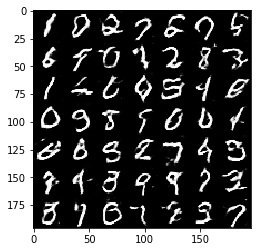

Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.2754
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.5262
Epoch 1/2... Discriminator Loss: 0.6661... Generator Loss: 1.4221


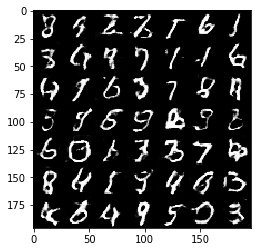

Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 1.7011
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.1234
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 2.1062
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.6644
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.5683
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.4772
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 1.3167
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.9662


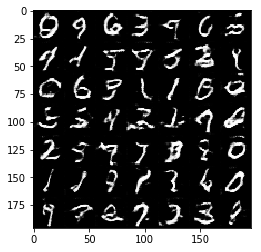

Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.7051
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.2443
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.1291
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.0794


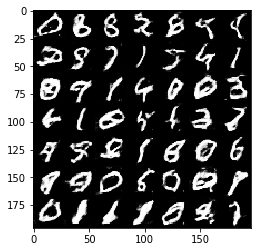

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 1.9091
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.3603
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.6334


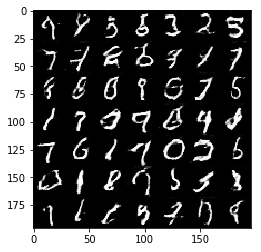

Epoch 2/2... Discriminator Loss: 1.8138... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 2.8829
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.0936
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.6345
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.0209


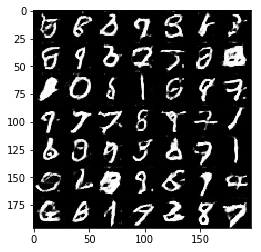

Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 2.8341
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.5469... Generator Loss: 1.4963
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.9414
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 1.7113
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.9417


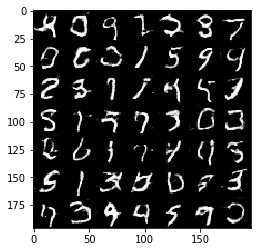

Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.2699
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.0228


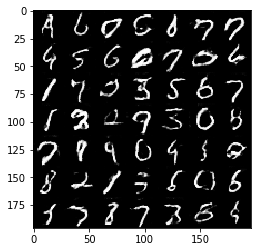

Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.7603
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.8506
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.2651
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.5805


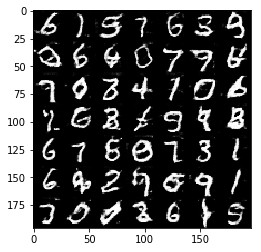

Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.6906
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 1.6675
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 2.4451
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 0.9075


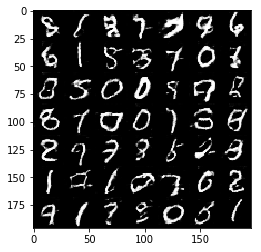

Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 2.2552
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.4927
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.7548
Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 2.0254
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.5433
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.0508


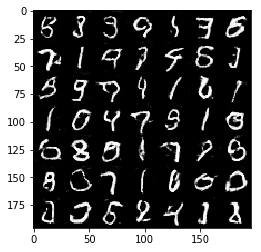

Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 1.8869
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.5754
Epoch 2/2... Discriminator Loss: 0.4582... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 2.4187
Epoch 2/2... Discriminator Loss: 0.4257... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.8678


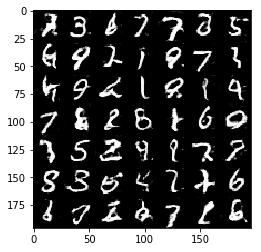

Epoch 2/2... Discriminator Loss: 0.6010... Generator Loss: 2.1322
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 2.0007
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.6658
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 2.0023
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.6581
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.5321


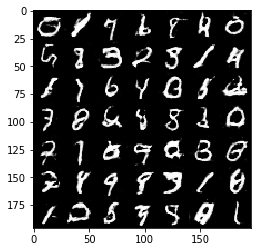

Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 2.0546
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.5568
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 2.1928
Epoch 2/2... Discriminator Loss: 0.6011... Generator Loss: 1.8467
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.3896
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 2.5087


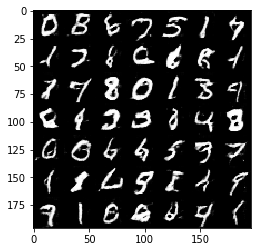

Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 1.0374
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 1.0239
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.2767
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 1.5536
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.2635


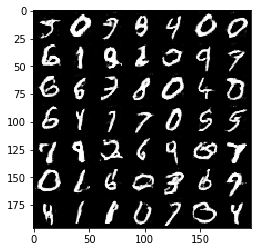

Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 1.6642
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.6096
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 1.3343
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 1.6302
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.0951
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.5722
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.7836
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.4706
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 1.6470


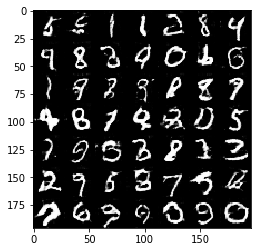

Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 1.5791... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 2.0473
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 2.4323
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.2389
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 2.0085
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 1.8952
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 0.7145


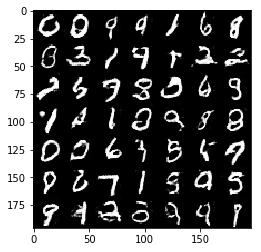

Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 0.7045... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.9698
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.3028
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.4704
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.7694
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.8262


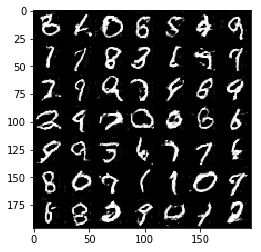

Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.3860
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.3593
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.6856
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 2.1036
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.6527
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 3.1519
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.9860


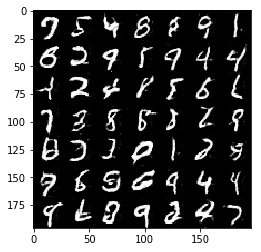

Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.4788
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.3490
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 1.8027... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.2168
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 0.5698... Generator Loss: 1.7636


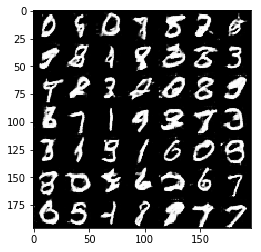

Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 2.3954
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 1.7799
Epoch 2/2... Discriminator Loss: 1.4738... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 2.5657
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.9890
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 0.6568


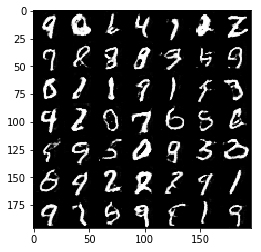

Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.0396
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 0.5233... Generator Loss: 1.6563
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 1.2905


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 2.4336
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 2.6073
Epoch 1/1... Discriminator Loss: 0.1672... Generator Loss: 2.5296
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 2.5968
Epoch 1/1... Discriminator Loss: 0.1768... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 2.9742
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.5098
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 3.4313
Epoch 1/1... Discriminator Loss: 0.2208... Generator Loss: 3.2375


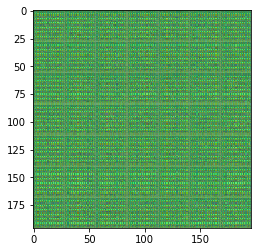

Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.2245
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 3.3444
Epoch 1/1... Discriminator Loss: 0.0935... Generator Loss: 3.6974
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 3.6690
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 4.1416
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.7665
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 4.1913
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 3.7915
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 3.9288
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 4.0514


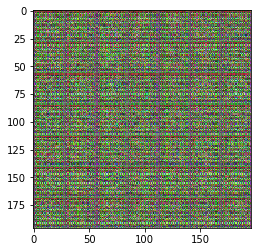

Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.2452
Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 4.2853
Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 4.5950
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 4.4084
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.7604
Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 4.0686
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 3.9733
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 4.6677
Epoch 1/1... Discriminator Loss: 0.0233... Generator Loss: 4.9808
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 4.7875


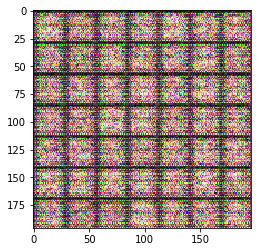

Epoch 1/1... Discriminator Loss: 0.0911... Generator Loss: 4.5083
Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 5.0807
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 5.2330
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 4.7398
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.2083
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 4.9041
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 5.1322
Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 4.7601
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 4.6166
Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 4.8419


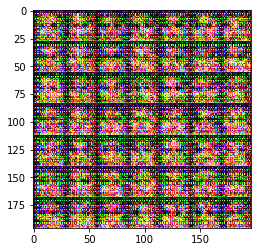

Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 5.1299
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 4.6367
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 5.2638
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 5.0643
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 5.2114
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 4.6387
Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 4.8607
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 4.5033
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 4.5397
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 2.1355


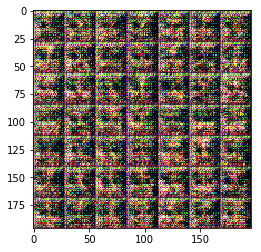

Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 3.9686
Epoch 1/1... Discriminator Loss: 0.0255... Generator Loss: 4.3190
Epoch 1/1... Discriminator Loss: 0.1184... Generator Loss: 3.7256
Epoch 1/1... Discriminator Loss: 0.1035... Generator Loss: 3.6855
Epoch 1/1... Discriminator Loss: 0.1119... Generator Loss: 3.1955
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 4.0652
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 3.1685
Epoch 1/1... Discriminator Loss: 0.0779... Generator Loss: 4.3904
Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 3.6940
Epoch 1/1... Discriminator Loss: 0.1610... Generator Loss: 4.0484


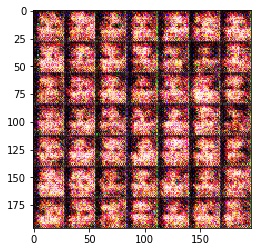

Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 4.6822
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 5.0261
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 3.9581
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 4.1040
Epoch 1/1... Discriminator Loss: 0.1385... Generator Loss: 3.6167
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.6836
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 5.1333
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 4.7982
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 4.4293
Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 4.1908


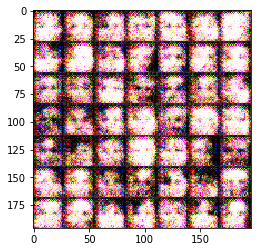

Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 4.7392
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 4.3721
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.7429
Epoch 1/1... Discriminator Loss: 0.2377... Generator Loss: 2.8816
Epoch 1/1... Discriminator Loss: 0.2151... Generator Loss: 2.5925
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 2.5533
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 2.5682
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 3.3736
Epoch 1/1... Discriminator Loss: 0.1088... Generator Loss: 3.8299


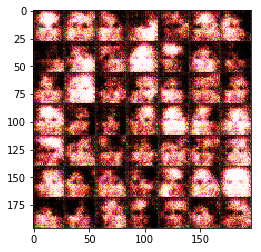

Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 3.2979
Epoch 1/1... Discriminator Loss: 0.1971... Generator Loss: 2.8515
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 3.7763
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 3.1037
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 3.7507
Epoch 1/1... Discriminator Loss: 0.1182... Generator Loss: 2.9216
Epoch 1/1... Discriminator Loss: 0.1517... Generator Loss: 3.2052
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.9515
Epoch 1/1... Discriminator Loss: 0.2939... Generator Loss: 2.5866
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 3.2727


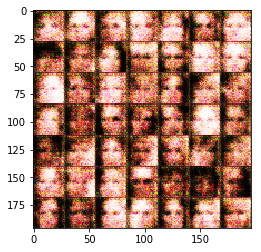

Epoch 1/1... Discriminator Loss: 0.1649... Generator Loss: 3.5042
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 3.2528
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 3.3083
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 2.2590
Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 2.8873
Epoch 1/1... Discriminator Loss: 0.2121... Generator Loss: 2.8297
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 2.2259
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 3.1329
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 3.5825


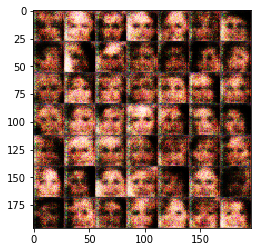

Epoch 1/1... Discriminator Loss: 0.2958... Generator Loss: 2.2039
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 2.8499
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 2.4514
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 2.6267
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 2.8839
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.3480
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 2.7033
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 2.9261
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 2.8361


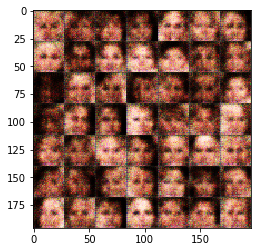

Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 1.9730
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 2.1637
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 2.2498
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 2.1703
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.6925
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 2.0887
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.3588
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.5471


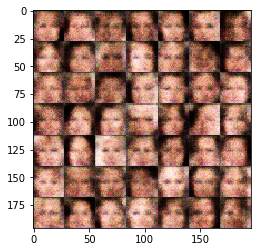

Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 2.5738
Epoch 1/1... Discriminator Loss: 0.2941... Generator Loss: 2.4939
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 2.6966
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 2.0164
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.3200... Generator Loss: 2.1344
Epoch 1/1... Discriminator Loss: 0.2474... Generator Loss: 2.6984
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 2.7581
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 3.2675


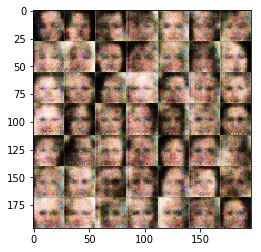

Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 2.2013
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 2.8857
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.4946
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 1.9822
Epoch 1/1... Discriminator Loss: 0.2863... Generator Loss: 2.1966
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.4660
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 2.4073
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 2.5076
Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 2.6411


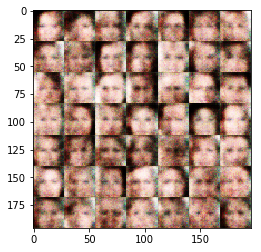

Epoch 1/1... Discriminator Loss: 0.3072... Generator Loss: 2.6569
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 3.0527
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.4343
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.6904
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.8223
Epoch 1/1... Discriminator Loss: 0.3003... Generator Loss: 2.9516
Epoch 1/1... Discriminator Loss: 0.2389... Generator Loss: 2.9656
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 3.1601
Epoch 1/1... Discriminator Loss: 0.2332... Generator Loss: 2.8100
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 2.4193


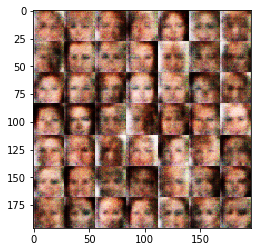

Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 2.2762
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 1.8081
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 2.0824
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.7731
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.9177


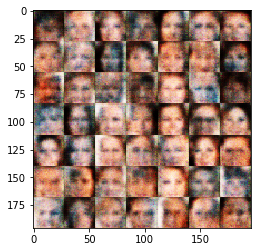

Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.9499
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 2.5046
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.2584
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 2.1258
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 2.1806
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.9760
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.6574


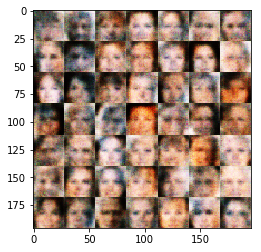

Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.2548
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.0763
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.3014
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 2.3638
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 2.1768
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.9263
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.1661
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 2.2316
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.0147


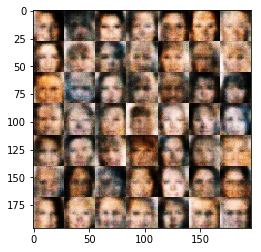

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 2.5319
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 2.1841
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 2.0143
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.7656
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.0688


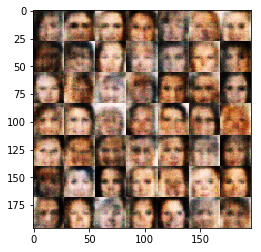

Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 2.3583
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.0001
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 2.6446
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 2.3621
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.0991
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.0746


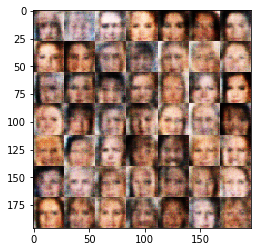

Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.8506
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.8265
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 2.4084
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.3863
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.5314
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 1.7803
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.7482


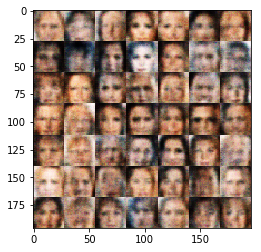

Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 2.8820
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 2.9889
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 3.0058
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.8924
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 2.8012
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.1082
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.8255
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 2.3513


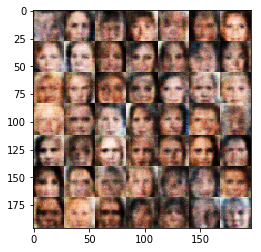

Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 2.6483
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 2.2840
Epoch 1/1... Discriminator Loss: 0.2671... Generator Loss: 2.4018
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.4191
Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 2.1446
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 2.5040
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.7639


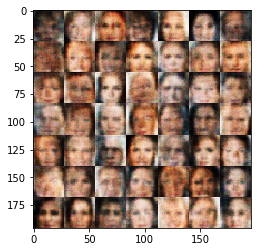

Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 2.5586
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 2.6773
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.8329
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 2.7100
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 2.0793
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 2.1185
Epoch 1/1... Discriminator Loss: 0.3246... Generator Loss: 2.9230


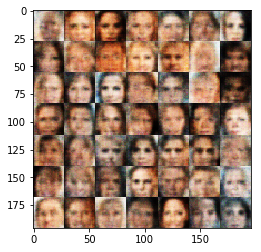

Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 3.1850
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.9175
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.7749
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 2.3690
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 2.6221
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.9239
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.9062
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 2.3261
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 2.7888
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 2.8630


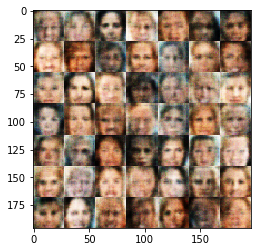

Epoch 1/1... Discriminator Loss: 0.2538... Generator Loss: 3.2701
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.2279
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 3.4688
Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 2.5517
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 2.9668
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 1.8712
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 2.5780
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.0578
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 1.7013


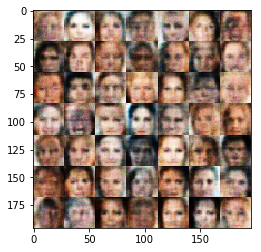

Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 2.1067
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 0.2960... Generator Loss: 2.2274
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 2.5974
Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 2.8497
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 3.4348
Epoch 1/1... Discriminator Loss: 0.2124... Generator Loss: 2.8360
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 1.9522
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 2.4259
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 2.6606


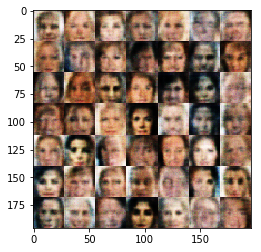

Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 2.3526
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 1.8811
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 2.1497
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.2687
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.0057
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 2.5080


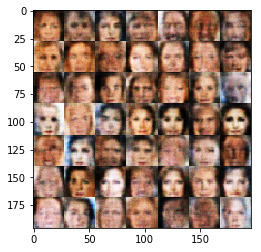

Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.0768
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 0.3180... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.2698
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 2.9173
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 2.3771
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 2.2097


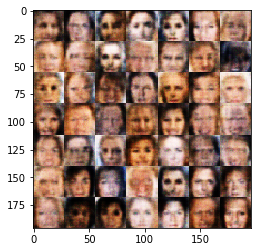

Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.9839
Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 2.0608
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.9477
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 2.0312
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 2.4521
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 2.6426
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.5039
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 1.9580
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.2084


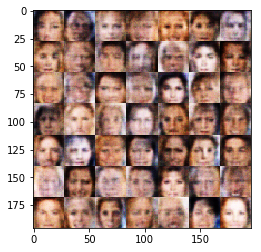

Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 2.1612
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.8880
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 2.4726
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.8966
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 2.1775
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 2.8111
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.3119


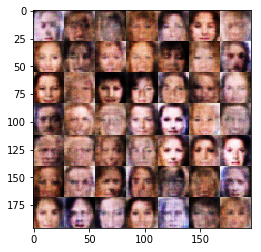

Epoch 1/1... Discriminator Loss: 0.2437... Generator Loss: 2.5453
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 2.5133
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 2.6075
Epoch 1/1... Discriminator Loss: 0.2007... Generator Loss: 2.4148
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 2.5260
Epoch 1/1... Discriminator Loss: 0.3015... Generator Loss: 2.3650
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.2468
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 2.3388
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 2.3254
Epoch 1/1... Discriminator Loss: 0.2869... Generator Loss: 2.9225


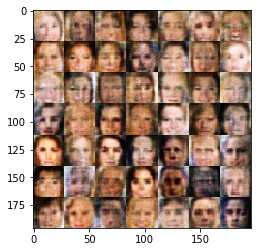

Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 2.6069
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 2.5936
Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 3.2357
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.0032
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.9259
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 2.0485
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.8239
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.8654


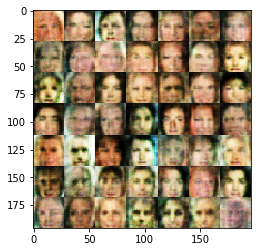

Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.1659
Epoch 1/1... Discriminator Loss: 0.2389... Generator Loss: 2.5884
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.3689


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 1e-5
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.